In [1]:
import numpy as np
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.utils.data

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation
import os

In [2]:
tracking2018 = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/tracking2018.csv")
tracking2019 = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/tracking2019.csv")
tracking2020 = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/tracking2020.csv")

tracking2018.head()

,time,x,y,s,a,dis,o,dir,event,nflId,displayName,jerseyNumber,position,team,frameId,gameId,playId,playDirection
0,2018-12-30T21:25:32.200,41.32,29.45,4.36,1.33,0.43,130.42,128.44,None,39470.0,Justin Tucker,9.0,K,home,1,2018123000,36,right
1,2018-12-30T21:25:32.300,41.68,29.17,4.59,1.24,0.45,128.59,127.81,None,39470.0,Justin Tucker,9.0,K,home,2,2018123000,36,right
2,2018-12-30T21:25:32.400,42.05,28.88,4.74,0.99,0.47,124.47,128.15,None,39470.0,Justin Tucker,9.0,K,home,3,2018123000,36,right
3,2018-12-30T21:25:32.500,42.43,28.59,4.87,0.71,0.48,126.02,127.35,None,39470.0,Justin Tucker,9.0,K,home,4,2018123000,36,right
4,2018-12-30T21:25:32.600,42.84,28.31,4.96,0.79,0.50,131.71,124.75,None,39470.0,Justin Tucker,9.0,K,home,5,2018123000,36,right


In [3]:
play_data = pd.read_csv("/home/amans/Development/scott/nfl-big-data-bowl-2022/csv/plays.csv")
returned_plays = play_data.query("specialTeamsResult == 'Return' and passResult.isnull() and penaltyYards.isnull() and (not returnerId.isnull())", engine='python', inplace=False)


In [4]:
data_df = pd.read_pickle('/home/amans/Development/scott/nfl-big-data-bowl-2022/clean_dir/ball_carrier_data.pkl')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [6]:
def split_data(dataset, train_split, seed):
    np.random.seed(seed)
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)

    train_num = int(len(dataset)*train_split)
    val_num = (len(dataset) - int(len(dataset)*train_split))//2

    train_indices = indices[0:train_num]
    val_indices = indices[train_num:train_num+val_num]
    test_indices = indices[train_num+val_num:]

    #check to make sure slices correct
    assert len(dataset) == len(train_indices) + len(val_indices) + len(test_indices)

    #dataset = help.normalize(train_indices, dataset)

    train_data = dataset.iloc[train_indices,:]
    val_data = dataset.iloc[val_indices,:]
    test_data = dataset.iloc[test_indices,:]

    return train_data, val_data, test_data

train_data, val_data, test_data = split_data(data_df, 0.7, 2430)


In [7]:
'''
Function that adds needed features to the play df
'''


def modify_play_df(play_df):
    # shift x-axis based on target's endzone
    playDirection = play_df.loc[play_df.index[0],'playDirection']
    
    if playDirection == 'left':
        play_df.insert(len(play_df.columns),'adj_x', play_df['x'])
        play_df.insert(len(play_df.columns),'adj_y', play_df['y'] - 26.65)
        # change dir and rotation
        play_df.insert(len(play_df.columns), 'adj_o', (play_df['o'] + 270) % 360)
        play_df.insert(len(play_df.columns), 'adj_dir', (play_df['dir'] + 270) % 360)
    if playDirection == 'right':
        
        play_df.insert(len(play_df.columns),'adj_x', 120 - play_df['x'])
        play_df.insert(len(play_df.columns),'adj_y', play_df['y'] - 26.65)
        # change dir and rotation
        play_df.insert(len(play_df.columns), 'adj_o', (play_df['o'] + 90) % 360)
        play_df.insert(len(play_df.columns), 'adj_dir', (play_df['dir'] + 90) % 360)
        
    play_df['adj_o'].round(2)
    play_df['adj_dir'].round(2)
    
    play_df.insert(len(play_df.columns), 'sin_adj_o', np.sin(play_df.loc[:,'adj_o']))
    play_df.insert(len(play_df.columns), 'cos_adj_o', np.cos(play_df.loc[:,'adj_o']))
    play_df.insert(len(play_df.columns), 'sin_adj_dir', np.sin(play_df.loc[:,'adj_dir']))
    play_df.insert(len(play_df.columns), 'cos_adj_dir', np.cos(play_df.loc[:,'adj_dir']))
    
    play_df = play_df.fillna(value=0)
    
    play_df.loc[:, 'next_x'] = play_df.groupby('displayName').x.shift(-1)
    play_df.loc[:, 'next_y'] = play_df.groupby('displayName').y.shift(-1)
    play_df.loc[:, 'next_dis'] = play_df.groupby('displayName').dis.shift(-1)
    play_df.loc[:, 'next_s'] = play_df.groupby('displayName').s.shift(-1)
    play_df.loc[:, 'next_a'] = play_df.groupby('displayName').a.shift(-1)
    play_df.loc[:, 'next_o'] = play_df.groupby('displayName').o.shift(-1)
    play_df.loc[:, 'next_dir'] = play_df.groupby('displayName').dir.shift(-1)
    play_df.loc[:, 'next_adj_x'] = play_df.groupby('displayName').adj_x.shift(-1)
    play_df.loc[:, 'next_adj_y'] = play_df.groupby('displayName').adj_y.shift(-1)
    play_df.loc[:, 'next_adj_o'] = play_df.groupby('displayName').adj_o.shift(-1)
    play_df.loc[:, 'next_adj_dir'] = play_df.groupby('displayName').adj_dir.shift(-1)
    play_df.loc[:, 'next_sin_adj_o'] = play_df.groupby('displayName').sin_adj_o.shift(-1)
    play_df.loc[:, 'next_cos_adj_o'] = play_df.groupby('displayName').cos_adj_o.shift(-1)
    play_df.loc[:, 'next_sin_adj_dir'] = play_df.groupby('displayName').sin_adj_dir.shift(-1)
    play_df.loc[:, 'next_cos_adj_dir'] = play_df.groupby('displayName').cos_adj_dir.shift(-1)
    
    # remove NAs created by shifting; i.e. remove plays where there is no next play
    play_df.dropna(axis=0, how='any', subset=['x'], inplace=True)
   
    return play_df

In [8]:
def get_distances(x, player_pos):
    dist = np.linalg.norm(player_pos.values - x.values)
    
    try:
        dist = round(dist, 3)
    except:
        dist = np.around(dist, 3)
    
    return dist

def min_teammate_distances(player_of_interest_row, time_play_df):
    team = player_of_interest_row['team_index']
    nflid = player_of_interest_row['nflId']
    new_df = time_play_df.query("team_index == @team and displayName != 'football' and nflId != @nflid")
    dists = new_df.loc[:,['adj_x','adj_y']].apply(get_distances, axis=1,args=(player_of_interest_row[['adj_x','adj_y']],))
    min_teammate_dist = min(dists)
    return min_teammate_dist

def min_opponent_distances(player_of_interest_row, time_play_df):
    team = player_of_interest_row['team_index']
    nflid = player_of_interest_row['nflId']
    new_df = time_play_df.query("team_index != @team and displayName != 'football' and nflId != @nflid")
    dists = new_df.loc[:,['adj_x','adj_y']].apply(get_distances, axis=1,args=(player_of_interest_row[['adj_x','adj_y']],))
    min_teammate_dist = min(dists)
    return min_teammate_dist

In [9]:
'''

def store_player_info(time_play_df, time_index, time_string, returnerId, gameId, season, playId, playDirection, ball_carrier_team, playerId):
    # now we can define the values for each row
    rowDict = {}
       
    ball_carrier_team = time_play_df.loc[time_play_df.nflId == returnerId, ['team']].values[0][0]

    other_team_name = 'home'
    if ball_carrier_team == 'home':
        other_team_name = 'away'

    # get distance from ball carrier
    ball_carrier_state = time_play_df.loc[time_play_df.nflId == returnerId, ['x','y', 's', 'a', 'o', 'dir']]
    time_play_df.insert(len(time_play_df.columns), 'dist_from_ball_carrier', time_play_df.loc[:,['x','y']].apply(get_distances, axis=1,args=(ball_carrier_state.loc[:, ['x','y']],)))

    time_play_df.insert(len(time_play_df.columns), 'ball_carrier_bool', time_play_df.nflId != returnerId)
    time_play_df.insert(len(time_play_df.columns), 'player_bool', time_play_df.nflId != playerId)
    time_play_df.insert(len(time_play_df.columns), 'football_bool', time_play_df.displayName != 'football')
    time_play_df.insert(len(time_play_df.columns), 'team_index', time_play_df.team == ball_carrier_team)

    time_play_df.sort_values(by=["player_bool", "football_bool", "team_index", "dist_from_ball_carrier"], inplace=True, ignore_index=True)

    football_index = time_play_df.index[time_play_df.team == 'football']
    no_football_df = time_play_df.query("displayName != 'football'")
    
    time_play_df.insert(len(time_play_df.columns), 'min_teammate_dist', time_play_df.apply(min_teammate_distances, axis=1, args=(no_football_df,)))
    time_play_df.insert(len(time_play_df.columns), 'min_opponent_dist', time_play_df.apply(min_teammate_distances, axis=1, args=(no_football_df,)))
    
    states = time_play_df.loc[:,['x','y', 'dis', 's', 'a', 'o', 'dir', 'adj_x', 'adj_y', 'adj_o', 'adj_dir', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir', 'dist_from_ball_carrier', 'min_teammate_dist', 'min_opponent_dist']].to_numpy()
    football_pos = time_play_df.loc[time_play_df.team == 'football',['x','y', 'dis', 's', 'a', 'o', 'dir', 'adj_x', 'adj_y', 'adj_o', 'adj_dir', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir', 'dist_from_ball_carrier', 'min_teammate_dist', 'min_opponent_dist']].to_numpy()
    
    rowDict['season'] = season
    rowDict['gameId'] = gameId
    rowDict['playId'] = playId

    rowDict["timeIndex"] = time_index
    rowDict["time"] = time_string
    rowDict["playerId"] = playerId
    rowDict["football_pos"] = football_pos
    # add current state
    rowDict['state'] = states
    # add future states
    next_state = time_play_df.loc[:,['next_x','next_y', 'next_dis', 'next_s', 'next_a', 'next_o', 'next_dir', 'next_adj_x', 'next_adj_y', 'next_adj_o', 'next_adj_dir', 'next_sin_adj_o', 'next_cos_adj_o', 'next_sin_adj_dir', 'next_cos_adj_dir']].to_numpy()
    rowDict['next_state'] = next_state
    # add reward - defined as ball carrier's increase in x
    ball_carrier = time_play_df.query("nflId == @returnerId")
    rowDict['reward'] = round(ball_carrier['adj_x'] - ball_carrier['next_x'],3).values

    action = states[:,:-3]- next_state
    rowDict['action'] = action.round(2)
    
    return rowDict
'''

def store_player_info(time_play_df, time_index, time_string, returnerId, gameId, season, playId, playDirection, ball_carrier_team, playerId):
    # now we can define the values for each row
    rowDict = {}
       
    ball_carrier_team = time_play_df.loc[time_play_df.nflId == returnerId, ['team']].values[0][0]

    other_team_name = 'home'
    if ball_carrier_team == 'home':
        other_team_name = 'away'

    # get distance from ball carrier
    ball_carrier_state = time_play_df.loc[time_play_df.nflId == returnerId, ['x','y', 's', 'a', 'o', 'dir']]
    time_play_df.insert(len(time_play_df.columns), 'dist_from_ball_carrier', time_play_df.loc[:,['x','y']].apply(get_distances, axis=1,args=(ball_carrier_state.loc[:, ['x','y']],)))

    time_play_df.insert(len(time_play_df.columns), 'ball_carrier_bool', time_play_df.nflId != returnerId)
    time_play_df.insert(len(time_play_df.columns), 'player_bool', time_play_df.nflId != playerId)
    time_play_df.insert(len(time_play_df.columns), 'football_bool', time_play_df.displayName != 'football')
    time_play_df.insert(len(time_play_df.columns), 'team_index', time_play_df.team == ball_carrier_team)

    time_play_df.sort_values(by=["player_bool", "football_bool", "team_index", "dist_from_ball_carrier"], inplace=True, ignore_index=True)

    football_index = time_play_df.index[time_play_df.team == 'football']
    no_football_df = time_play_df.query("displayName != 'football'")
    
    time_play_df.insert(len(time_play_df.columns), 'min_teammate_dist', time_play_df.apply(min_teammate_distances, axis=1, args=(no_football_df,)))
    time_play_df.insert(len(time_play_df.columns), 'min_opponent_dist', time_play_df.apply(min_opponent_distances, axis=1, args=(no_football_df,)))
    
    states = time_play_df.loc[:,['x','y', 'dis', 's', 'a', 'o', 'dir', 'adj_x', 'adj_y', 'adj_o', 'adj_dir', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir', 'dist_from_ball_carrier', 'min_teammate_dist', 'min_opponent_dist']].to_numpy()
    football_pos = time_play_df.loc[time_play_df.team == 'football',['x','y', 'dis', 's', 'a', 'o', 'dir', 'adj_x', 'adj_y', 'adj_o', 'adj_dir', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir', 'dist_from_ball_carrier', 'min_teammate_dist', 'min_opponent_dist']].to_numpy()
    
    rowDict['season'] = season
    rowDict['gameId'] = gameId
    rowDict['playId'] = playId

    rowDict["timeIndex"] = time_index
    rowDict["time"] = time_string
    rowDict["playerId"] = playerId
    rowDict["football_pos"] = football_pos
    # add current state
    rowDict['state'] = states
    # add future states
    next_state = time_play_df.loc[:,['next_x','next_y', 'next_dis', 'next_s', 'next_a', 'next_o', 'next_dir', 'next_adj_x', 'next_adj_y', 'next_adj_o', 'next_adj_dir', 'next_sin_adj_o', 'next_cos_adj_o', 'next_sin_adj_dir', 'next_cos_adj_dir']].to_numpy()
    rowDict['next_state'] = next_state
    # add reward - defined as ball carrier's increase in x
    ball_carrier = time_play_df.query("nflId == @returnerId")
    rowDict['reward'] = round(ball_carrier['adj_x'] - ball_carrier['next_x'],3).values

    action = states[:,:-3]- next_state
    rowDict['action'] = action.round(2)
    
    return rowDict



In [10]:
'''
Function that returns the model that outputs the entire next state
'''

def return_models(device, action_size):

    model = nn.Sequential(
        nn.Linear(184,230), 
        nn.LeakyReLU(),
        nn.Linear(230,action_size*23)
    )
    
    model.to(device)
    
    model.load_state_dict(torch.load("full_dataset_model.pt"))
    
    return model

In [11]:
'''
Function that takes in a engineered feature vector from store_player_info and a model. Outputs a prediction
def get_prediction_from_true(play, model, state_size, loss_fn, device):
    
    with torch.no_grad():
        
        numpy_state = np.stack(play['state'].values)
        batch_size = numpy_state.shape[0]

        true_state = torch.tensor(np.stack(play['state'].values)[:,:,[3,4,7,8,11,12,13,14]].reshape(batch_size, -1), dtype=torch.float32).to(device=device)
        true_next_state = torch.tensor(np.stack(play['next_state'].values)[:,:,[3,4,7,8,11,12,13,14]].reshape(batch_size, -1), dtype=torch.float32).to(device=device)

        model.eval()  # put model to eval mode

        #compute prediction and loss
        predicted_next_state = model(true_state)
    
        loss = loss_fn(predicted_next_state, true_next_state)
    
    return predicted_next_state, true_next_state, loss
'''

def get_prediction_from_true(play, model, state_size, loss_fn, device):
    
    with torch.no_grad():
        
        numpy_state = play['state']
        batch_size = numpy_state.shape[0]

        true_state = torch.tensor(numpy_state[:,[3,4,7,8,11,12,13,14]].reshape(1, -1), dtype=torch.float32).to(device=device)
        true_next_state = torch.tensor(play['next_state'][:,[3,4,7,8,11,12,13,14]].reshape(1, -1), dtype=torch.float32).to(device=device)

        model.eval()  # put model to eval mode

        #compute prediction and loss
        predicted_next_state = model(true_state)
    
        loss = loss_fn(predicted_next_state, true_next_state)
    
    return predicted_next_state, true_next_state, loss


'''
Function that gets prediction from previous predicted state
'''
def get_prediction_from_pred(returnerId, playerId, time_play_df, ball_carrier_team, model, device, previous_state):
    
    no_cuda = previous_state.detach().cpu()
    df = pd.DataFrame(no_cuda)
    df.columns = ['s', 'a', 'adj_x', 'adj_y', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir']

    other_team_name = 'home'
    if ball_carrier_team == 'home':
        other_team_name = 'away'

    df['displayName'] = time_play_df.displayName
    df['nflId'] = time_play_df.nflId

    # get distance from ball carrier
    ball_carrier_state = time_play_df.loc[time_play_df.nflId == returnerId, :]
    df['dist_from_ball_carrier'] = time_play_df.loc[:,['adj_x','adj_y']].apply(get_distances, axis=1,args=(ball_carrier_state.loc[:, ['adj_x','adj_y']],))

    df['ball_carrier_bool'] = time_play_df.nflId != returnerId
    df['player_bool'] = time_play_df.nflId != playerId
    df['football_bool'] = time_play_df.displayName != 'football'
    df['team_index'] = time_play_df.team == ball_carrier_team

    df.sort_values(by=["player_bool", "football_bool", "team_index", "dist_from_ball_carrier"], inplace=True, ignore_index=True)

    no_football_df = df.query("displayName != 'football'")

    df['min_teammate_dist'] = df.apply(min_teammate_distances, axis=1, args=(no_football_df,))
    df['min_opponent_dist'] = df.apply(min_opponent_distances, axis=1, args=(no_football_df,))
    
    arr = np.array(df.iloc[:, 0:8], dtype=np.dtype(float)).reshape(1,-1)

    tensor_input = torch.tensor(arr, dtype=torch.float32).to(device)
    
    model.eval()
    predicted_action = model(tensor_input)

    return predicted_action

In [12]:
'''
Given a play from the play csv (not the tracking csv), returns a torch tensor of the FIRST state (relative to when
the ball carrier receives the ball). Is a (23,8) tensor with columns 
['s', 'a', 'adj_x', 'adj_y', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir']
'''

def get_tensor_state(play, device):
    
    gameId = play.loc['gameId']
    playId = play.loc['playId']
    returnerId = float(play.loc['returnerId'])
    season = str(gameId)[0:4]

    # load DF with all plays, to get info about the plays
    if season == '2019':
        play_df = tracking2019.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2018':
        play_df = tracking2018.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2020':
        play_df = tracking2020.query('playId == @playId and gameId == @gameId', inplace=False)
    else:
        print(f"could not find game for game {gameId}, play {playId}")
        return None

    playDirection = play_df.loc[play_df.index[0],'playDirection']
    # modifies in place
    play_df = modify_play_df(play_df)
    
    events = list(np.unique(play_df.event))
    
    if 'kick_received' in events or 'punt_received' in events:
        received_time = play_df.query("event == 'kick_received' or event == 'punt_received'").time.iloc[0]
    else:
        print("Could not get info from play with events ", events)
        return None
    if 'tackle' in events or 'out_of_bounds' in events or 'touchdown' in events or 'fumbled' in events:
        tackled_time = play_df.query("event == 'tackle' or event == 'out_of_bounds' or event == 'touchdown' or event == 'fumbled'").time.iloc[0]
    else:
        print("Could not get info from play with events ", events)
        return None
    
    runner_times = play_df.query("time >= @received_time and time <= @tackled_time")

    # iterate through the times
    all_times = list(np.unique(runner_times.time))
    time_string = all_times[0]
    
    time_play_df = runner_times.query("time == @time_string", inplace=False).reset_index()
    
    df_subset = time_play_df.loc[:, ['s', 'a', 'adj_x', 'adj_y', 'sin_adj_o', 'cos_adj_o', 'sin_adj_dir', 'cos_adj_dir']]
    arr = np.array(df_subset, dtype=np.dtype(float) )
    tensor_input = torch.tensor(arr, dtype=torch.float32).to(device)
    
    return tensor_input

In [13]:
'''
Home=1
Away=0
Football=2
'''

def get_home_away(play, device):

    gameId = play.loc['gameId']
    playId = play.loc['playId']
    returnerId = float(play.loc['returnerId'])
    playerId = returnerId
    season = str(gameId)[0:4]

    # load DF with all plays, to get info about the plays
    if season == '2019':
        play_df = tracking2019.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2018':
        play_df = tracking2018.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2020':
        play_df = tracking2020.query('playId == @playId and gameId == @gameId', inplace=False)
    else:
        print(f"could not find game for game {gameId}, play {playId}")
        return None

    playDirection = play_df.loc[play_df.index[0],'playDirection']
    # modifies in place
    play_df = modify_play_df(play_df)

    # inspect each time
    # received_time = np.unique(play_df.query("event == 'kick_received'").time)[0]
    # tackled_time = np.unique(play_df.query("event == 'tackle'").time)[0]
    
    events = list(np.unique(play_df.event))
    
    if 'kick_received' in events or 'punt_received' in events:
        received_time = play_df.query("event == 'kick_received' or event == 'punt_received'").time.iloc[0]
    else:
        print("Could not get info from play with events ", events)
        return None
    if 'tackle' in events or 'out_of_bounds' in events or 'touchdown' in events or 'fumbled' in events:
        tackled_time = play_df.query("event == 'tackle' or event == 'out_of_bounds' or event == 'touchdown' or event == 'fumbled'").time.iloc[0]
    else:
        print("Could not get info from play with events ", events)
        return None

    runner_times = play_df.query("time >= @received_time and time <= @tackled_time")

    # iterate through the times
    all_times = list(np.unique(runner_times.time))
    time_string = all_times[0]

    time_play_df = runner_times.query("time == @time_string", inplace=False).reset_index()
    
    ball_carrier_team = time_play_df.loc[time_play_df.nflId == returnerId, ['team']].values[0][0]

    other_team_name = 'home'
    if ball_carrier_team == 'home':
        other_team_name = 'away'

    # get distance from ball carrier
    ball_carrier_state = time_play_df.loc[time_play_df.nflId == returnerId, ['x','y', 's', 'a', 'o', 'dir']]
    time_play_df.insert(len(time_play_df.columns), 'dist_from_ball_carrier', time_play_df.loc[:,['x','y']].apply(get_distances, axis=1,args=(ball_carrier_state.loc[:, ['x','y']],)))

    time_play_df.insert(len(time_play_df.columns), 'ball_carrier_bool', time_play_df.nflId != returnerId)
    time_play_df.insert(len(time_play_df.columns), 'player_bool', time_play_df.nflId != playerId)
    time_play_df.insert(len(time_play_df.columns), 'football_bool', time_play_df.displayName != 'football')
    time_play_df.insert(len(time_play_df.columns), 'team_index', time_play_df.team == ball_carrier_team)

    time_play_df.sort_values(by=["player_bool", "football_bool", "team_index", "dist_from_ball_carrier"], inplace=True, ignore_index=True)

    team_list = [1 if x == 'home' else 0 for x in time_play_df.team]
    home_away_arr = np.array(team_list)
    
    football_index = time_play_df.index[time_play_df.team == 'football']
    
    home_away_arr[football_index] = 2
    
    return home_away_arr

In [14]:
'''
Given a single play from Returned_Plays csv, predict the play
'''

def calc_preds(play):

    state_size = len(test_data.iloc[0,8][0])
    NUM_PLAYERS = 23     # includes football
    ACTION_SIZE = 8

    #play = returned_plays.iloc[2,:]
    gameId = play.loc['gameId']
    playId = play.loc['playId']
    returnerId = float(play.loc['returnerId'])
    season = str(gameId)[0:4]

    # load DF with all plays, to get info about the plays
    if season == '2019':
        play_df = tracking2019.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2018':
        play_df = tracking2018.query('playId == @playId and gameId == @gameId', inplace=False)
    elif season == '2020':
        play_df = tracking2020.query('playId == @playId and gameId == @gameId', inplace=False)
    else:
        print(f"could not find game for game {gameId}, play {playId}")
        return None, None, None, None

    playDirection = play_df.loc[play_df.index[0],'playDirection']
    # modifies in place
    play_df = modify_play_df(play_df)

    events = list(np.unique(play_df.event))
    
    if 'kick_received' in events or 'punt_received' in events:
        received_time = play_df.query("event == 'kick_received' or event == 'punt_received'").time.iloc[0]
    else:
        print("Could not get info from play with events ", events)
        return None, None, None, None
    if 'tackle' in events or 'out_of_bounds' in events or 'touchdown' in events or 'fumbled' in events:
        tackled_time = play_df.query("event == 'tackle' or event == 'out_of_bounds' or event == 'touchdown' or event == 'fumbled'").time.iloc[0]
    else:
        print("Could not get info from play with events ", events)
        return None, None, None, None
    
    runner_times = play_df.query("time >= @received_time and time <= @tackled_time")

    full_model = return_models(device, ACTION_SIZE)
    mse_loss_fn = nn.MSELoss()

    # iterate through the times
    all_times = list(np.unique(runner_times.time))

    states_from_true = torch.zeros((len(all_times), NUM_PLAYERS, ACTION_SIZE)).to(device)
    states_from_predicted = torch.zeros((len(all_times), NUM_PLAYERS, ACTION_SIZE)).to(device)
    all_true_states = torch.zeros((len(all_times), NUM_PLAYERS, ACTION_SIZE)).to(device)
    total_loss = 0

    for time_index, time_string in enumerate(all_times[:-1]):

        time_play_df_orig = runner_times.query("time == @time_string", inplace=False).reset_index()
        time_play_df = time_play_df_orig.copy(deep=True)
        # should already be sorted by nflId by construction of the dataset, but doing just to make sure
        #time_play_df.sort_values(by=["nflId"], inplace=True, ignore_index=True)

        ball_carrier_team = time_play_df.loc[time_play_df.nflId == returnerId, ['team']].values[0][0]

        if time_index == 0:
            model_preprocessed_input = store_player_info(time_play_df, time_index, time_string, returnerId, gameId, season, playId, playDirection, ball_carrier_team, returnerId)

            predicted_next_state, true_next_state, loss = get_prediction_from_true(model_preprocessed_input, full_model, state_size, mse_loss_fn, device)

            predicted_next_state = predicted_next_state.view(NUM_PLAYERS, ACTION_SIZE)
            true_next_state = true_next_state.view(NUM_PLAYERS, ACTION_SIZE)

            states_from_true[time_index] = predicted_next_state
            states_from_predicted[time_index] = predicted_next_state
            all_true_states[time_index] = true_next_state

            total_loss += loss

        else:

            # get prediction from true action
            model_preprocessed_input = store_player_info(time_play_df, time_index, time_string, returnerId, gameId, season, playId, playDirection, ball_carrier_team, returnerId)
            predicted_next_state, true_next_state, loss = get_prediction_from_true(model_preprocessed_input, full_model, state_size, mse_loss_fn, device)
            # get prediction from true prediction

            predicted_next_state2 = get_prediction_from_pred(returnerId, returnerId, time_play_df, ball_carrier_team, full_model, device, states_from_predicted[time_index-1].view(NUM_PLAYERS, ACTION_SIZE))

            predicted_next_state = predicted_next_state.view(NUM_PLAYERS, ACTION_SIZE)
            predicted_next_state2 = predicted_next_state2.view(NUM_PLAYERS, ACTION_SIZE)
            true_next_state = true_next_state.view(NUM_PLAYERS, ACTION_SIZE)

            states_from_true[time_index] = predicted_next_state
            states_from_predicted[time_index] = predicted_next_state2
            all_true_states[time_index] = true_next_state

            total_loss += loss

        #if time_index % 5 == 0:
        #    print(f"Done with {time_index} out of {len(all_times)}")

    print("Finished play")
    
    return states_from_true, states_from_predicted, all_true_states, total_loss

In [15]:
'''
Test to see how the data is sorted.
Is sorted by nflId
'''

#time_play_df.sort_values(by=["nflId"], inplace=True, ignore_index=True)

#display(time_play_df)


'\nTest to see how the data is sorted.\nIs sorted by nflId\n'

In [16]:
'''
Get play identification from test data, returned play from Returned_Plays. Pass into predict function
'''

def get_returned_play(test_index, test_data, returned_plays):
    
    test_data_entry = test_data.reset_index().iloc[test_index, ]
    
    gameId = test_data_entry.loc['gameId']
    playId = test_data_entry.loc['playId']
    
    returned_plays_entry = returned_plays.query("gameId == @gameId and playId == @playId").iloc[0,:]
    
    return returned_plays_entry

In [17]:
get_returned_play(0, test_data, returned_plays)

gameId                                                           2018112506
playId                                                                  760
playDescription           A.Rosas kicks 67 yards from NYG 35 to PHI -2. ...
quarter                                                                   1
down                                                                      0
yardsToGo                                                                 0
possessionTeam                                                          NYG
specialTeamsPlayType                                                Kickoff
specialTeamsResult                                                   Return
kickerId                                                            43937.0
returnerId                                                            45599
kickBlockerId                                                           NaN
yardlineSide                                                            NYG
yardlineNumb

In [29]:
display(play_to_viz)

gameId                                                           2018111102
playId                                                                  955
playDescription           M.Bosher kicks 62 yards from ATL 35 to CLE 3. ...
quarter                                                                   2
down                                                                      0
yardsToGo                                                                 0
possessionTeam                                                          ATL
specialTeamsPlayType                                                Kickoff
specialTeamsResult                                                   Return
kickerId                                                            37267.0
returnerId                                                            44837
kickBlockerId                                                           NaN
yardlineSide                                                            ATL
yardlineNumb

In [22]:
def calc_yards_ran(calc_preds_output):
    try:
        play_states_cpu = calc_preds_output.detach().cpu()
    except:
        play_states_cpu = calc_preds_output
    start_x = play_states_cpu[0][0,2]
    end_x = play_states_cpu[-2][0,2]
    yards_ran = end_x - start_x

    return round(float(yards_ran), 3)


true_yards_ran = calc_yards_ran(all_true_states)
expected_yards_ran = calc_yards_ran(states_from_predicted)
goe = round(expected_yards_ran - true_yards_ran, 3)

print(goe)

-0.274


In [69]:
test_index = 2

play_to_viz = get_returned_play(test_index, test_data, returned_plays)

first_state = get_tensor_state(play_to_viz, device)
home_away = get_home_away(play_to_viz, device)

# states_from_true
# states_from_predicted
# all_true_states
# total_loss

states_from_true, states_from_predicted, all_true_states, total_loss = calc_preds(play_to_viz)

Finished play


In [19]:
states_from_predicted[0, :, 2:4]

print(total_loss/43)


tensor(0.2946, device='cuda:0')


<IPython.core.display.Javascript object>


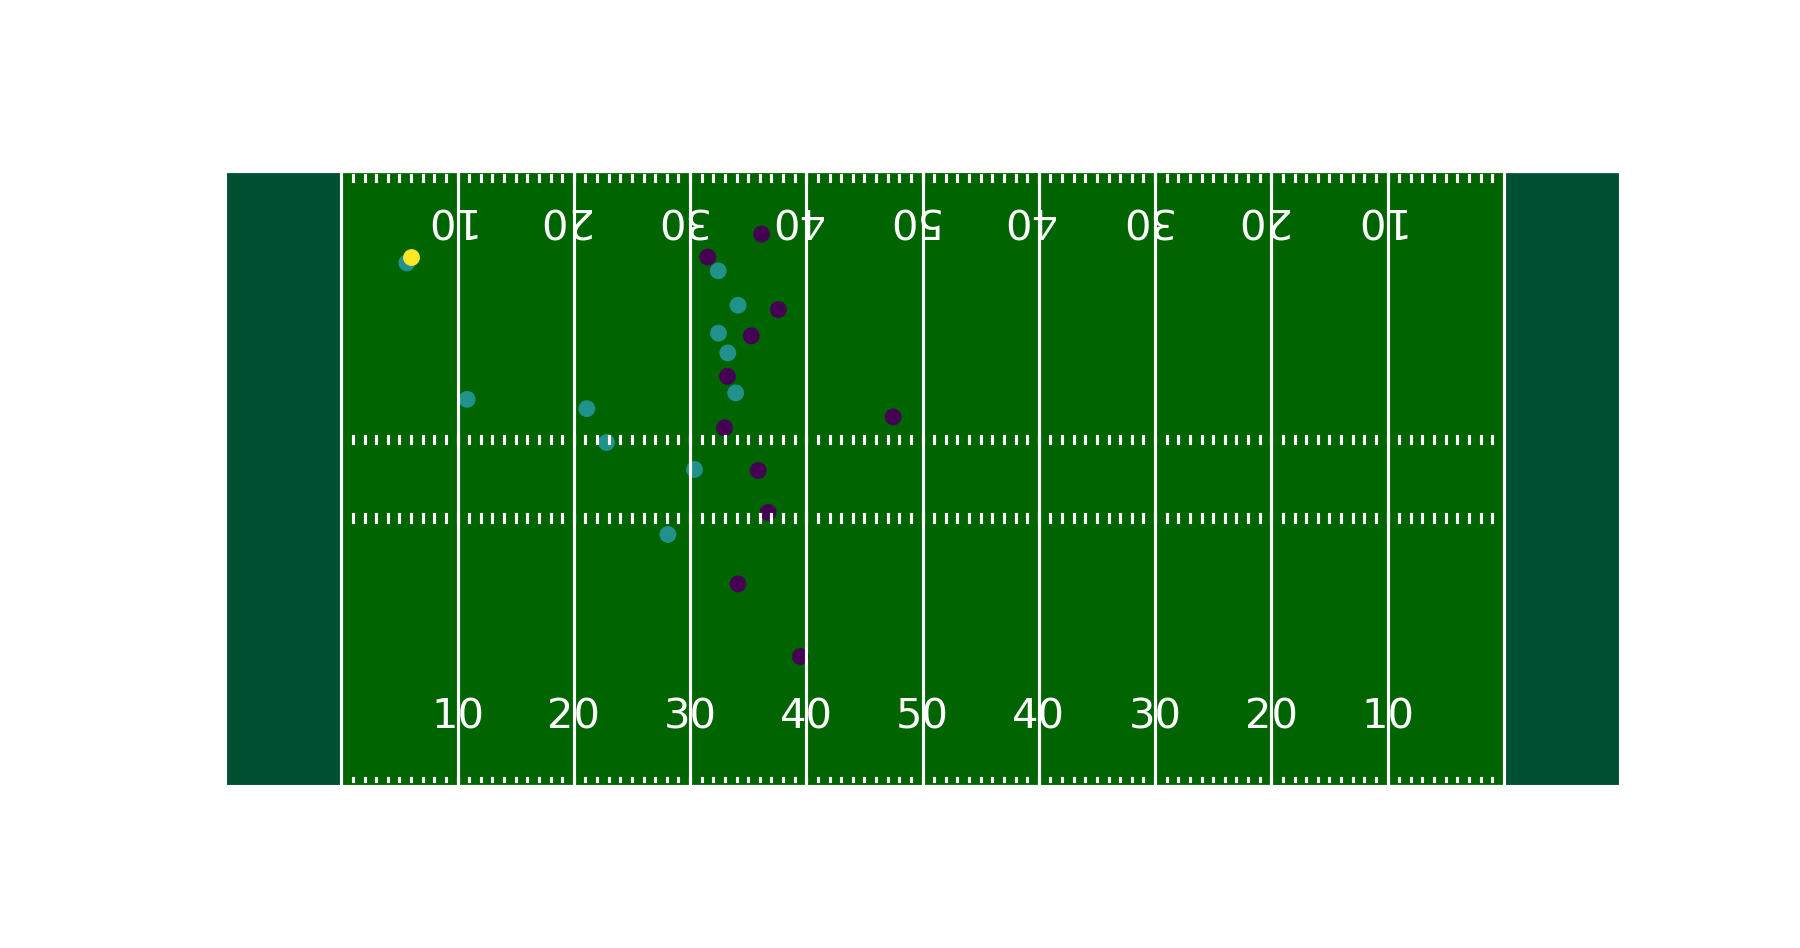

In [73]:
'''
Visualize predictions
'''

%matplotlib notebook

def update_plot(i, predicted_states_cpu, home_away, scat):
    
    data = np.zeros((23, 2))
    data[:,0] = np.array(predicted_states_cpu[i][:,2])
    data[:,1] = np.array(predicted_states_cpu[i][:,3] + 26)
    
    scat.set_array(home_away)
    scat.set_offsets(data)
    
    return scat,

numframes = all_true_states.shape[0]-17
numpoints = 10

predicted_states_cpu = np.array(states_from_predicted.detach().cpu())

i=0

fig, ax = create_football_field()
scat = ax.scatter(predicted_states_cpu[i][:,2], predicted_states_cpu[i][:,3] + 26, c=home_away, s=50)

ani = FuncAnimation(fig, update_plot, frames=numframes, fargs=(predicted_states_cpu, home_away, scat))
plt.show()

In [78]:
ani.save('prediction_far_to_true.gif', writer='imagemagick', fps=12)

In [79]:
from IPython.display import Image

Image(url='prediction_far_to_true.gif')

In [76]:
from matplotlib import animation

writervideo = animation.FFMpegWriter(fps=12)
ani.save('prediction_far_to_true.mp4', writervideo)

In [77]:
from IPython.display import Video

Video('prediction_far_to_true.mp4', width=900)

<IPython.core.display.Javascript object>


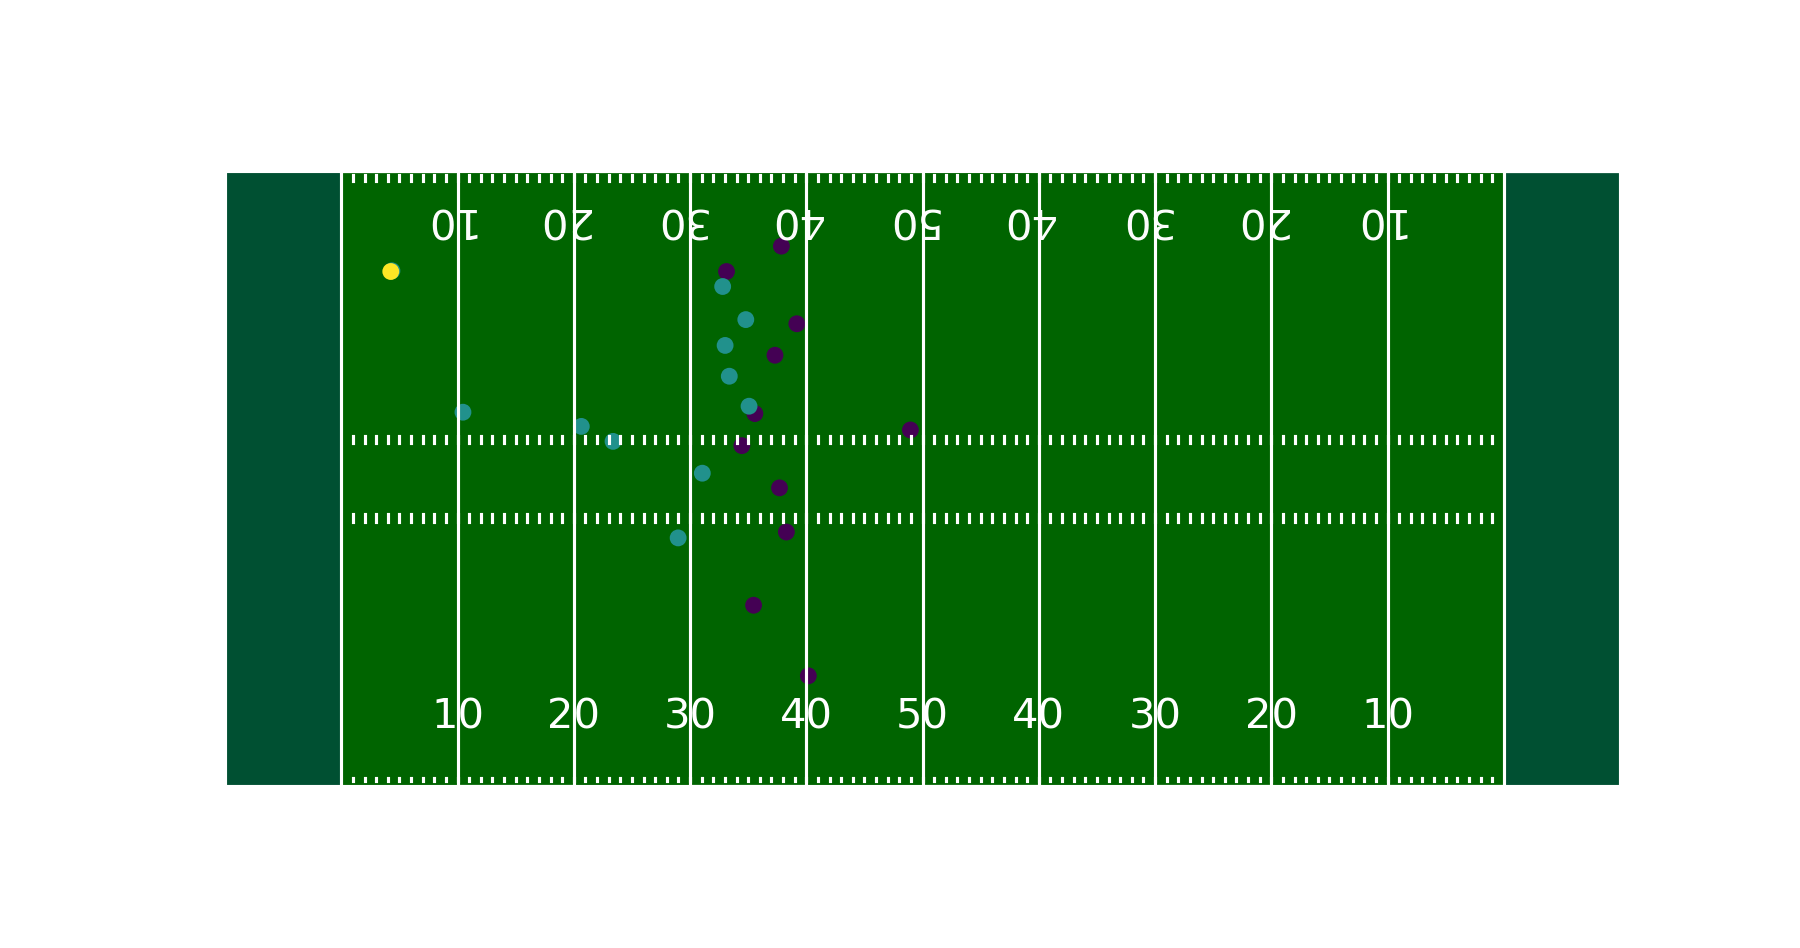

In [80]:
'''
Vizualize true play
'''
%matplotlib notebook

def update_plot(i, true_states_cpu, home_away, scat):
    
    data = np.zeros((23, 2))
    data[:,0] = np.array(true_states_cpu[i][:,2])
    data[:,1] = np.array(true_states_cpu[i][:,3] + 26)
    
    scat.set_array(home_away)
    scat.set_offsets(data)
    
    return scat,

numframes = all_true_states.shape[0]
numpoints = 10

true_states_cpu = np.array(all_true_states.detach().cpu())

i=0

fig2, ax2 = create_football_field()
scat2 = ax2.scatter(true_states_cpu[i][:,2], true_states_cpu[i][:,3] + 26, c=home_away, s=50)

ani2 = FuncAnimation(fig2, update_plot, frames=numframes, fargs=(true_states_cpu, home_away, scat2))
plt.show()

In [81]:
ani2.save('true_far_to_true.mp4', writervideo)

In [82]:
from IPython.display import Video

Video('true_far_to_true.mp4', width=900)

In [83]:
ani2.save('true_far_to_true.gif', writer='imagemagick', fps=12)

In [84]:
from IPython.display import Image

Image(url='true_far_to_true.gif')

In [ ]:
# states_from_true
# states_from_predicted
# all_true_states
# total_loss

print(f"Length of play = {len(all_true_states)}")

ind = 42

# true 
fig4, ax4 = create_football_field()

true_states_cpu = np.array(all_true_states.detach().cpu())

scat = ax4.scatter(true_states_cpu[ind][:,2], true_states_cpu[ind][:,3] + 26, c=home_away, s=50)

# predicted from true
fig3, ax3 = create_football_field()

states_from_true_cpu = np.array(states_from_true.detach().cpu())

scat = ax3.scatter(states_from_true_cpu[ind][:,2], states_from_true_cpu[ind][:,3] + 26, c=home_away, s=50)

# predicted from predicted
fig5, ax5 = create_football_field()

states_from_predicted_cpu = np.array(states_from_predicted.detach().cpu())

scat = ax5.scatter(states_from_predicted_cpu[ind][:,2], states_from_predicted_cpu[ind][:,3] + 26, c=home_away, s=50)

plt.show()


In [21]:
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax